In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/labs/amit/noamsh/repos/MM_2023')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from clinical_predictions.clinical_data_loading import generate_refracrotines_dataset 
from clinical_predictions.utils import balanced_subsample

In [4]:
from clinical_predictions.evaluation import train_and_eval_model, generate_datasets_summerization

In [56]:
from functools import partial

import optuna
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, cross_validate
from xgboost import XGBClassifier
import sklearn

def objective(trial, X_train, y_train):

    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-1, 1e3, log=True)
         model = sklearn.svm.SVC(C=svc_c, gamma='auto')
    elif classifier_name == 'Lasso':
         lasso_alpha = trial.suggest_float('lasso_alpha', 1e-1, 1e3, log=True)
         model = sklearn.linear_model.Lasso(alpha=lasso_alpha)
    elif classifier_name == 'RandomForest':
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 2, 16, log=True)
        model = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    elif classifier_name == 'LogisticRegression':
        logistic_regression_c = trial.suggest_float('logistic_regression_c', 1e-1, 1e3, log=True)
        model = sklearn.linear_model.LogisticRegression(C=logistic_regression_c)
    else:
        param = {
            'booster': trial.suggest_categorical('xgb_booster', ['gbtree', 'gblinear', 'dart']),
            'n_estimators': trial.suggest_int('xgb_n_estimators', 2, 16, log=True), 
            'max_depth': trial.suggest_int('xgb_max_depth', 1, 3), 
            # 'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
        }
        model = XGBClassifier(**param)
        
    # subsample = trial.suggest_categorical('subsample', [True, False])
    # if subsample:
    #     subsample_indexs = balanced_subsample(y_train)
    #     X_train = X_train.loc[subsample_indexs]
    #     y_train = y_train.loc[subsample_indexs]
    
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring = ['accuracy', 'precision', 'f1'])
    prec_alpha = 0.5
    mean_f1_prec_score = np.mean(scores['test_f1']  + scores['test_precision'] * prec_alpha)
    
    trial.set_user_attr(key="best_booster", value=model)
    return mean_f1_prec_score


def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


def get_best_model_with_optuna(X_train, y_train, n_trials=30):
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective, X_train=X_train, y_train=y_train), n_trials=n_trials, callbacks=[callback])
    best_model = study.user_attrs["best_booster"]
    best_trail = study.best_trial
    return best_model, best_trail

## loading

In [57]:
dataset_path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/MARS_SPID_exp_clin_nmf.xlsx'
raw_hospital_path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/Annonymized_CRF_BP_14112023S_SYW.xlsx'

In [58]:
raw_dataset = pd.read_excel(dataset_path)
raw_hospital_dataset = pd.read_excel(raw_hospital_path)
print(raw_dataset.shape)
# raw_dataset.head()

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



(262, 539)


In [59]:
print(raw_hospital_dataset.shape)
# raw_hospital_dataset.head()

(211, 111)


## general data filter

In [60]:
from clinical_predictions.clinical_data_loading import merge_transcriptom_data_to_raw_hospital

# remove no-transcriptom patients
# add post treatment columns
# add data to TAL_3 patients

dataset = merge_transcriptom_data_to_raw_hospital(raw_dataset, raw_hospital_dataset)

In [135]:
# path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/MARS_SPID_merged_with_hospital_231203.xlsx'
# dataset.to_excel(path)

### features selection

In [61]:
nmf_features = [f"X{i + 1}" for i in range(6)]
npc_composition = ["B", "B_Pro", "DC", "DC_IRF8", "Erythrocytes", "Fibro", "Mast", "Mf", "Mo", "Mo_CD16", "Neu_Pro",
                   "NK", "pDC", "T_Effector", "T_Effector_GZMB", "T_Naive", "UN"]
# clinical_feats = 

feats = nmf_features # + npc_composition


### label selection

In [112]:
datasets = {}
for treatment in ["Carfilzomib", "Lenalidomide", "Pomalidomide", "DARA", "CART", "Bortezomib", "Belantamab"]:

    if treatment == "CART":
        non_ref_policy = "NDMM-POST_TREATMENT_REF"
    else:
        non_ref_policy = "NDMM"

    # non_ref_policy = "NON_EXPOSED"

    X,y = generate_refracrotines_dataset(dataset, treatment, non_ref_policy, feats)
    
    datasets[treatment] = (X, y)

In [113]:
pd.concat([y.value_counts().rename(treatment) for treatment, (_, y) in datasets.items()], axis=1)

,Carfilzomib,Lenalidomide,Pomalidomide,DARA,CART,Bortezomib,Belantamab
0,24,24,24,24,40,24,24
1,20,60,31,46,3,51,7


In [114]:
good_treatments_data_sets = ["Bortezomib", "Lenalidomide", "Carfilzomib", "DARA", "Pomalidomide", "Belantamab"]

## model training

In [115]:
from sklearn.model_selection import train_test_split, GridSearchCV

good_splited_datasets = {}

for treatment in good_treatments_data_sets:
    X, y = datasets[treatment]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    good_splited_datasets[treatment] = X_train, X_test, y_train, y_test


In [116]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

monitor = {}

for treatment in tqdm(good_splited_datasets):
    X_train, X_test, y_train, y_test = good_splited_datasets[treatment]
    model, best_trial = get_best_model_with_optuna(X_train, y_train, n_trials=25)
    monitor[treatment] = train_and_eval_model(X_train, X_test, y_train, y_test, model, extra_for_report=best_trial.params)


  0%|          | 0/6 [00:00<?, ?it/s][I 2023-12-03 21:38:32,874] A new study created in memory with name: no-name-53f0c9f8-d3fa-43a9-819b-51ab611c72a9
/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:38:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:38:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:38:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:38:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

In [117]:
generate_datasets_summerization(monitor)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,0_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Bortezomib,34,18,17,6,19.0,4.0,0.736842,0.823529,0.777778,17.0,0.652174,0.818182,0.529412,0.642857,17.0,0.565217,"XGBClassifier(base_score=None, booster='gbline...","{'classifier': 'XGBoost', 'xgb_booster': 'gbli..."
Lenalidomide,40,18,20,6,26.0,NaN,0.769231,1.000000,0.869565,20.0,0.769231,0.705882,0.600000,0.648649,20.0,0.500000,"XGBClassifier(base_score=None, booster='gbtree...","{'classifier': 'XGBoost', 'xgb_booster': 'gbtr..."
Carfilzomib,14,16,6,8,4.0,10.0,1.000000,0.666667,0.800000,6.0,0.857143,0.666667,0.666667,0.666667,6.0,0.714286,"RandomForestClassifier(max_depth=11, n_estimat...","{'classifier': 'RandomForest', 'rf_max_depth':..."
DARA,32,17,14,7,21.0,NaN,0.666667,1.000000,0.800000,14.0,0.666667,0.666667,0.714286,0.689655,14.0,0.571429,"XGBClassifier(base_score=None, booster='gbtree...","{'classifier': 'XGBoost', 'xgb_booster': 'gbtr..."
Pomalidomide,22,16,9,8,14.0,3.0,0.571429,0.888889,0.695652,9.0,0.588235,0.777778,0.777778,0.777778,9.0,0.764706,"XGBClassifier(base_score=None, booster='dart',...","{'classifier': 'XGBoost', 'xgb_booster': 'dart..."
Belantamab,6,15,1,9,1.0,9.0,0.000000,0.000000,0.000000,1.0,0.800000,0.000000,0.000000,0.000000,1.0,0.600000,"RandomForestClassifier(max_depth=8, n_estimato...","{'classifier': 'RandomForest', 'rf_max_depth':..."


In [118]:
list(generate_datasets_summerization(monitor)["extra"])

["{'classifier': 'XGBoost', 'xgb_booster': 'gblinear', 'xgb_n_estimators': 4, 'xgb_max_depth': 2}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'gbtree', 'xgb_n_estimators': 3, 'xgb_max_depth': 2}",
 "{'classifier': 'RandomForest', 'rf_max_depth': 11, 'rf_n_estimators': 3}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'gbtree', 'xgb_n_estimators': 4, 'xgb_max_depth': 1}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'dart', 'xgb_n_estimators': 9, 'xgb_max_depth': 1}",
 "{'classifier': 'RandomForest', 'rf_max_depth': 8, 'rf_n_estimators': 4}"]

## train a stage model

In [119]:
mask = ~ dataset["Stage"].isna()
X_stage = dataset[mask][feats]
y_stage = dataset[mask]["Stage"]
y_is_stage_3 = (y_stage == 3).astype(int)
y_0_is_1 = y_stage.apply(lambda x: x if x == 0 else x-1).astype(int)
y_stage.value_counts()

Stage
3.0    98
2.0    17
1.0     7
0.0     3
Name: count, dtype: int64

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.2, random_state=42)

model, best_trial = get_best_model_with_optuna(X_train, y_train, n_trials=50)

monitor_stage = {}
monitor_stage["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)
print(best_trial.params)

[I 2023-12-03 21:39:30,941] A new study created in memory with name: no-name-a61cc959-3b97-4650-8b4e-a8b1671a8dc5
/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:39:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:39:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:39:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[21:39:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.


/home/labs/amit/noamsh/.conda/envs

{'classifier': 'XGBoost', 'xgb_booster': 'dart', 'xgb_n_estimators': 3, 'xgb_max_depth': 2}


/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [121]:
generate_datasets_summerization(monitor_stage)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Stage,78,22,20,5,25,0.8,1.0,0.888889,20.0,0.8,0.8125,0.65,0.722222,20.0,0.6,"XGBClassifier(base_score=None, booster='dart',...",


In [122]:
monitor_stage["Stage"].model

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

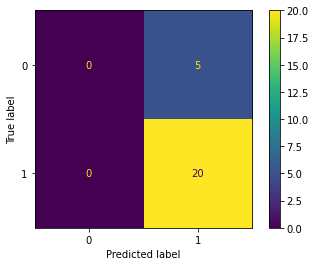

In [123]:
y_pred = monitor_stage["Stage"].y_pred
y_test = monitor_stage["Stage"].y_test
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [124]:
### train no search with sub sample

In [125]:
monitor_stage = {}

model = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1)

X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.3, random_state=42)

# subsample = balanced_subsample(y_train)
# X_train = X_train.loc[subsample]
# y_train = y_train.loc[subsample]

monitor_stage["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)

generate_datasets_summerization(monitor_stage)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,0_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Stage,67,20,31,7,32,6,0.84375,0.870968,0.857143,31.0,0.763158,0.814815,0.709677,0.758621,31.0,0.631579,"XGBClassifier(base_score=None, booster=None, c...",


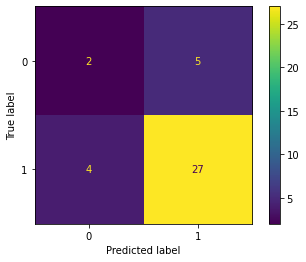

In [126]:
y_pred = monitor_stage["Stage"].y_pred
y_test = monitor_stage["Stage"].y_test
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [127]:
FP = y_test[(y_test==0).values & (y_pred==1).values] 
y_stage.loc[FP.index]

PID
HMC17    2.0
TLV09    1.0
TLV26    1.0
HMC09    0.0
TLV53    2.0
Name: Stage, dtype: float64

In [128]:
def bootstap_model_metric_distribution(model, X, y, n_samples, metric_name="f1-score"):
    baseline_f1_list = []
    model_f1_list = []
    for i in tqdm(range(n_samples)):
        X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.3, random_state=42+i)
        exp_data = train_and_eval_model(X_train, X_test, y_train, y_test, model)
        model_f1_list.append(exp_data.report["1"][metric_name])
        baseline_f1_list.append(exp_data.report["baseline"]["1"][metric_name])
    return model_f1_list, baseline_f1_list

In [129]:
def build_f1_df(model_f1_list, baseline_f1_list, contranst_name, metric_name):
    f1_df = pd.DataFrame({"model":["NMF model"] * len(model_f1_list) + ["baseline - random"] * len(baseline_f1_list),
                      metric_name :model_f1_list + baseline_f1_list})
    f1_df["contrast"] = contranst_name
    return f1_df
    

In [130]:
f1_dfs = []
metric_name = "accuracy" # recall, precision, f1-score, accuracy
for treatment, exp_data in monitor.items():
    best_model = exp_data.model
    X = pd.concat([exp_data.X_train, exp_data.X_test], axis=0)
    y = pd.concat([exp_data.y_train, exp_data.y_test], axis=0)
    
    model_f1_list, baseline_f1_list = bootstap_model_metric_distribution(model, X, y, n_samples=20, metric_name=metric_name) # recall, precision, f1-score
    
    f1_dfs.append(build_f1_df(model_f1_list, baseline_f1_list, treatment, metric_name))

model_f1_list, baseline_f1_list = bootstap_model_metric_distribution(XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1),
                                                                 X_stage, y_is_stage_3, n_samples=20, metric_name=metric_name)
f1_dfs.append(build_f1_df(model_f1_list, baseline_f1_list, "Stage", metric_name))
f1_df = pd.concat(f1_dfs, axis=0)

100%|██████████| 20/20 [00:00<00:00, 44.03it/s]


In [131]:
f1_df

,model,accuracy,contrast
0,NMF model,0.763158,Bortezomib
1,NMF model,0.631579,Bortezomib
2,NMF model,0.684211,Bortezomib
3,NMF model,0.789474,Bortezomib
4,NMF model,0.657895,Bortezomib
...,...,...,...
35,baseline - random,0.657895,Stage
36,baseline - random,0.763158,Stage
37,baseline - random,0.552632,Stage
38,baseline - random,0.684211,Stage


In [132]:
import plotly.express as px
fig = px.box(f1_df, color="model", x="contrast" ,y=metric_name,points="all",  width=800, height=400) #X for diffrent datasets
fig.update(layout_yaxis_range = [0,1])
fig.show()

In [133]:
### train no search with no sub sample

In [134]:
monitor_stage = {}

model = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1)

X_train, X_test, y_train, y_test = train_test_split(X_stage, y_0_is_1, test_size=0.3, random_state=42)
monitor_stage["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)

monitor_stage["Stage"].report

ValueError: 'a' and 'p' must have same size

In [ ]:

y_pred = monitor_stage["Stage"].y_pred
y_test = monitor_stage["Stage"].y_test
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()